In [1]:
%matplotlib inline

from pathlib import Path
import time
import traceback

import numpy as np
import pandas as pd
import scipy.stats as stats
pd.set_option('display.max_rows', 50)

import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')


import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Analyses.spatial_functions as sf
import TreeMazeAnalyses2.Analyses.open_field_functions as of
import TreeMazeAnalyses2.Analyses.tree_maze_functions as tmf
import TreeMazeAnalyses2.Analyses.plot_functions as pf
#import TreeMazeAnalyses2.Analyses.cluster_match_functions as cmf

from importlib import reload

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
ei = reload(ei)
info = ei.SummaryInfo()

## Goal:

given that HD coding cells were more likely to remap during the TM, we examine the directionality of the HD cells in relation to how cells coded in the tree-maze.

For matched units:
1) OF- need the extracted HD angle and RVL (resulting vector lenght)
2) TM - need an index of directionality in the meaze. 

### Hypothesis:
1. given that HD cells remap, they will do so as a function of preferred direction
2. alternatively, they will gain activity along another direction.


In [3]:
matched_unit_table = info.get_unit_match_table()
clustered_table = info.get_matched_of_cell_clusters()

print(matched_unit_table.head())
print(clustered_table.head())

   match_cl_id subject          session_T3    session_OF  cl_id_T3  cl_id_OF  \
0            0      Li  Li_T3i_061218_0001  Li_OF_061318       438       458   
1            0      Li       Li_T3g_061318  Li_OF_061318       476       458   
2            1      Li       Li_T3g_061518  Li_OF_062618       563       778   
3            1      Li       Li_T3g_061818  Li_OF_062618       614       778   
4            2      Li       Li_T3g_061818  Li_OF_061818       613       587   

                          cl_name_T3                    cl_name_OF  \
0  Li_T3i_061218_0001-tt3_d17.5_cl10    Li_OF_061318-tt3_d17.5_cl1   
1        Li_T3g_061318-tt3_d17.5_cl5    Li_OF_061318-tt3_d17.5_cl1   
2       Li_T3g_061518-tt3_d17.75_cl1  Li_OF_062618-tt3_d17.75_cl15   
3       Li_T3g_061818-tt3_d17.75_cl7  Li_OF_062618-tt3_d17.75_cl15   
4       Li_T3g_061818-tt3_d17.75_cl6  Li_OF_061818-tt3_d17.75_cl14   

   session_cl_id_T3  session_cl_id_OF  match_pair_number  
0                 0                 1  

In [4]:
%%time
ei = reload(ei)
info = ei.SummaryInfo()
table = info.get_hd_tm_scores_matched_clusters_data(overwrite=True)

CPU times: user 25min, sys: 25 s, total: 25min 25s
Wall time: 4min 12s


In [21]:
table

,match_cl_id,match_pair_number,cluster,subject,umap_1,umap_2,of_hd_ang,of_hd_score,tm_uz_stem_cue,tm_uz_left_cue,...,tm_uz_left_rw,tm_uz_right_rw,tm_remap_cue,tm_remap_rw,tm_All,tm_CR,tm_CL,tm_Co,tm_Inco,tm_xsamp
0,0,0,0,Li,-3.854654,2.271504,1.076356,0.365053,NaN,NaN,...,NaN,NaN,NaN,NaN,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N
1,0,1,0,Li,-3.854654,2.271504,1.076356,0.365053,0.1844,1.661583,...,2.040715,-0.171802,-0.477471,-0.992209,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,-0.094617-0.040437j
2,1,0,1,Li,2.951423,0.263405,1.566120,0.055527,0.498023,0.457152,...,0.21039,-4.608173,0.202963,-1.901687,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,-0.014547+0.011860j
3,1,1,1,Li,2.951423,0.263405,1.566120,0.055527,0.26513,-0.824801,...,2.696086,-3.089598,-0.478512,-1.335404,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,-0.059964-0.010244j
4,2,0,2,Li,9.045257,-0.002619,1.223314,0.058340,1.137033,1.080373,...,1.771543,-2.962975,-0.183025,-0.372746,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,N00000000a00000000N,-0.060054-0.024410j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,213,0,2,Ca,8.037321,-0.146413,-0.636024,0.058752,0.252153,0.142134,...,1.981735,0.525105,0.621142,0.568547,-0.001543+0.000698j,-0.001838+0.007101j,-0.001927-0.003759j,-0.003094-0.000245j,-0.001554+0.001180j,0.015564-0.078212j
303,214,0,1,Ca,5.244091,0.836049,-0.842138,0.055150,-0.072044,0.0,...,-0.165145,-0.945189,-0.472366,0.446098,0.001398+0.001156j,0.002273+0.002992j,0.001590-0.001011j,0.001494+0.001732j,0.001337+0.000243j,0.026746-0.104957j
304,214,1,1,Ca,5.244091,0.836049,-0.842138,0.055150,-0.392005,0.61978,...,-0.190826,-0.738549,0.356789,0.186027,0.000236+0.000963j,0.000231+0.001970j,0.000013+0.000499j,-0.001575+0.002117j,0.000581+0.001286j,0.068925+0.031453j
305,215,0,1,Ca,3.908710,1.039502,1.097803,0.035599,0.567098,-0.025425,...,-2.325551,-0.612372,-0.010541,0.006612,0.001650-0.000460j,0.001311-0.000262j,0.002008-0.000987j,0.001763+0.000703j,0.001469-0.001485j,0.055937+0.125668j


In [15]:
si = info.get_session('Li_T3g_061318')
ta = si.get_trial_analyses(speed_blank=True)

mr = si.get_bigseg_cond_rates(speed_blank=True)

In [19]:
tmf = reload(tmf)
h = tmf.tm_hdt_cond(mr, 'All')
h

,R,mag,ang
0,-0.013317+0.230075j,0.230460,1.628614
1,0.022278-0.056594j,0.060820,-1.195784
2,-0.169445-0.100707j,0.197113,-2.605350
3,0.033407-0.021903j,0.039947,-0.580341
4,0.046384+0.089933j,0.101190,1.094616
5,-0.041071+0.020799j,0.046037,2.672830
6,0.056048+0.292021j,0.297351,1.381172
7,0.066013+0.136056j,0.151225,1.119066
8,0.024237+0.214629j,0.215993,1.458347
9,0.035426+0.161551j,0.165390,1.354927


(array([ 8., 23.,  5.,  9.,  7.,  5.,  9., 24., 28., 24., 41., 43., 25.,
        24., 10., 12., 10.]),
 array([-180.        , -158.82352941, -137.64705882, -116.47058824,
         -95.29411765,  -74.11764706,  -52.94117647,  -31.76470588,
         -10.58823529,   10.58823529,   31.76470588,   52.94117647,
          74.11764706,   95.29411765,  116.47058824,  137.64705882,
         158.82352941,  180.        ]),
 <BarContainer object of 17 artists>)

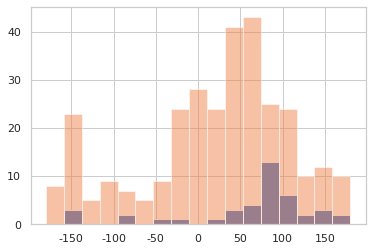

In [7]:
bins = np.linspace(-180,180,18)
plt.hist(np.rad2deg(np.angle(table['tm_All'])), bins=bins)
plt.hist(np.rad2deg(table['of_hd_ang']),bins=bins,alpha=0.5)

(array([ 8., 23.,  5.,  9.,  7.,  5.,  9., 24., 28., 24., 41., 43., 25.,
        24., 10., 12., 10.]),
 array([-180.        , -158.82352941, -137.64705882, -116.47058824,
         -95.29411765,  -74.11764706,  -52.94117647,  -31.76470588,
         -10.58823529,   10.58823529,   31.76470588,   52.94117647,
          74.11764706,   95.29411765,  116.47058824,  137.64705882,
         158.82352941,  180.        ]),
 <BarContainer object of 17 artists>)

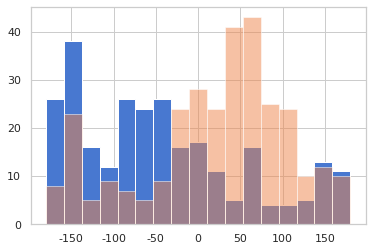

In [8]:
bins = np.linspace(-180,180,18)
plt.hist(np.rad2deg(np.angle(table['tm_xsamp'])), bins=bins)
plt.hist(np.rad2deg(table['of_hd_ang']),bins=bins,alpha=0.5)

<AxesSubplot:xlabel='of_hd_ang'>

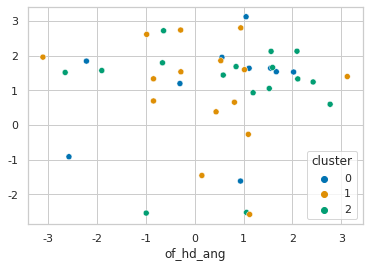

In [9]:
sns.scatterplot(x='of_hd_ang',y=np.angle(table['tm_All']), hue='cluster', data=table, palette='colorblind')

<AxesSubplot:xlabel='of_hd_ang'>

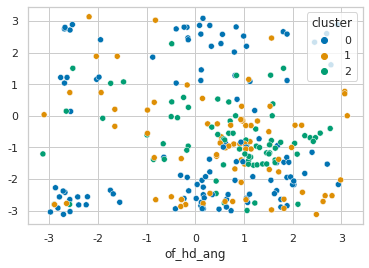

In [14]:
sns.scatterplot(x='of_hd_ang',y=np.angle(table['tm_xsamp']), hue='cluster', data=table, palette='colorblind')

<AxesSubplot:xlabel='of_hd_score', ylabel='tm_All'>

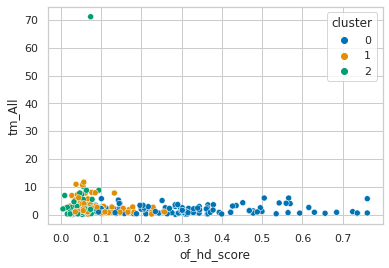

In [8]:
sns.scatterplot(x='of_hd_score',y=np.abs(table['tm_All']), hue='cluster', data=table, palette='colorblind')

<AxesSubplot:xlabel='of_hd_score', ylabel='tm_xsamp'>

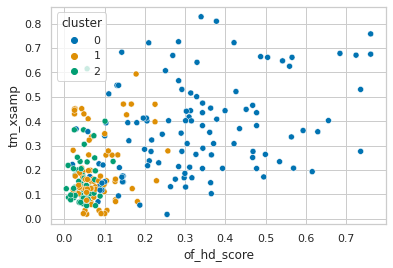

In [11]:
sns.scatterplot(x='of_hd_score',y=np.abs(table['tm_xsamp']), hue='cluster', data=table, palette='colorblind')

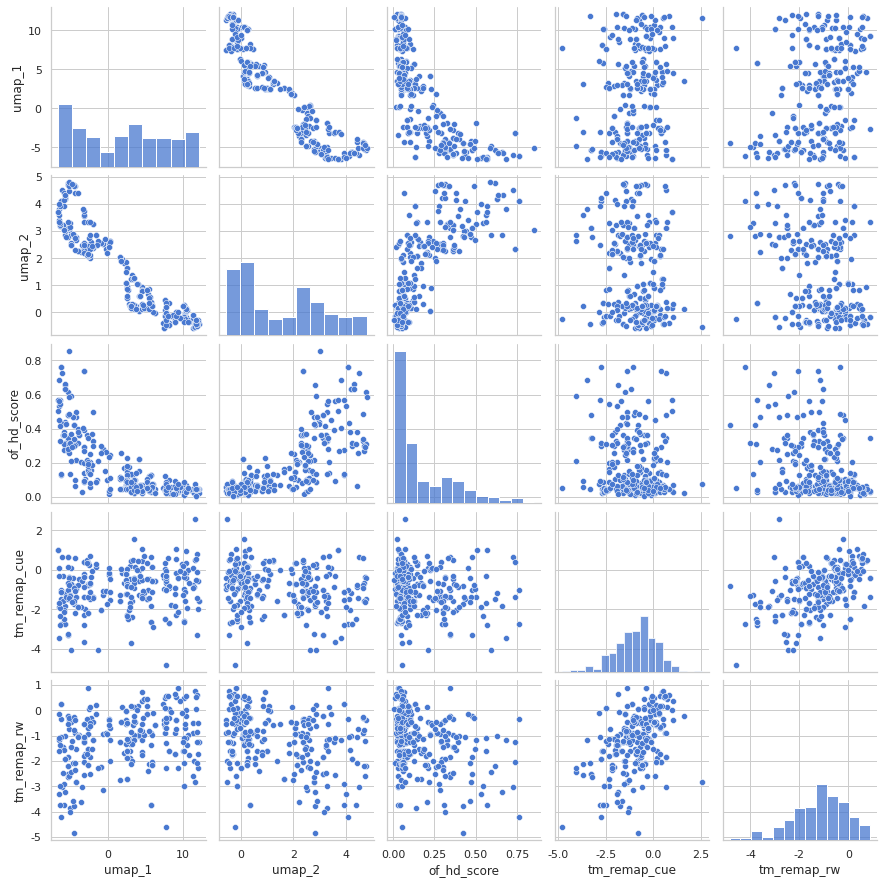

In [25]:

c_vars=['umap_1','umap_2', 'of_hd_score', 'tm_remap_cue', 'tm_remap_rw']
sns.pairplot(data=table[c_vars])

<AxesSubplot:xlabel='umap_1', ylabel='tm_remap_rw'>

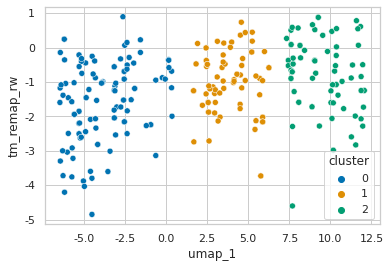

In [26]:
sns.scatterplot(table['umap_1'], table['tm_remap_rw'], hue=table['cluster'], palette='colorblind')

In [54]:
cols = ['tm_All', 'tm_Co', 'tm_Inco','tm_CR', 'tm_CL']
addcols = ['cluster','umap_1', 'of_hd_score', 'tm_remap_cue', ]
tm_angles = table[cols].apply(np.angle)
tm_mags = table[cols].apply(np.abs)
tm_mags[addcols] = table[addcols]
tm_angles[addcols] = table[addcols]

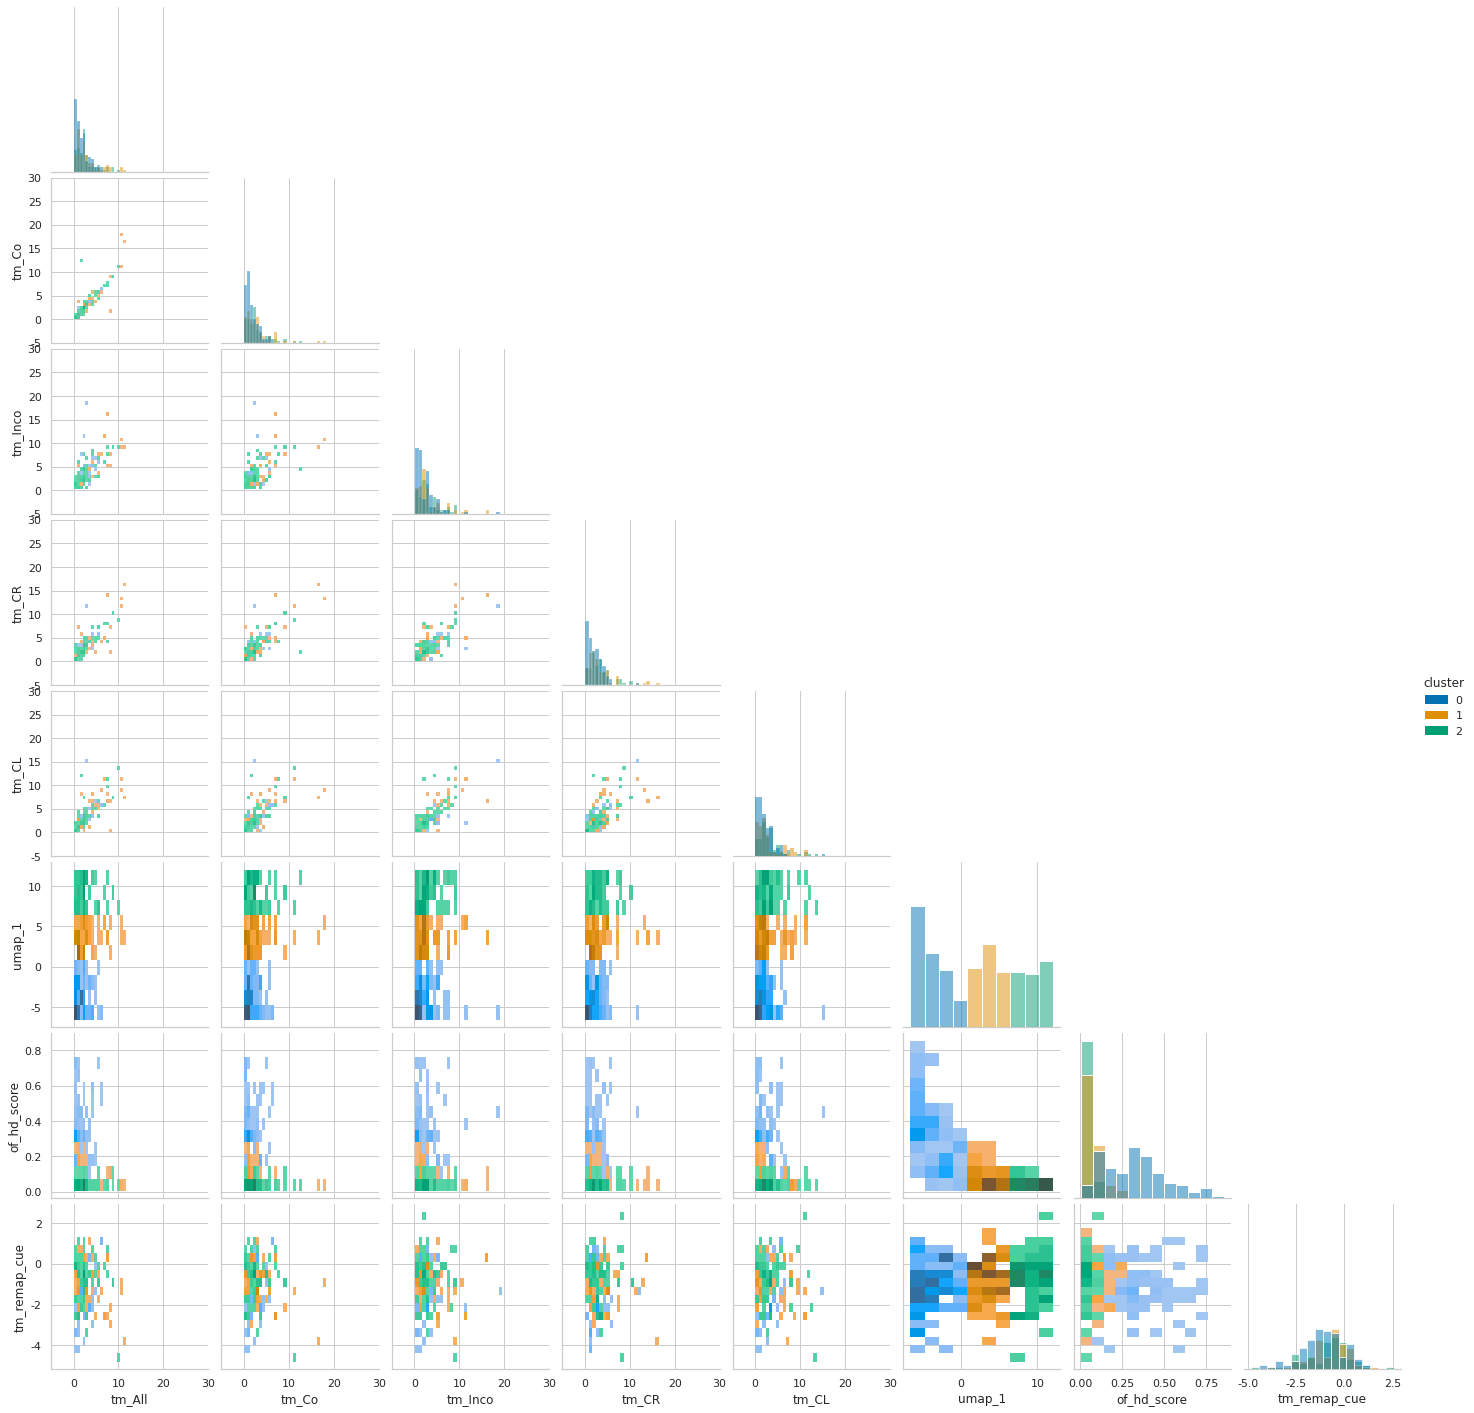

In [58]:
a = sns.pairplot(tm_mags, kind='hist', corner=True, hue='cluster', palette='colorblind', dropna=True)
for ii in range(5):
    for jj in range(5):
        if ii>jj:
            a.axes[ii,jj].set_xlim([-5,30])
            a.axes[ii,jj].set_ylim([-5,30])
        elif ii==jj:
            a.axes[ii,jj].set_xlim([-5,30])


In [56]:
tm_mags

,tm_All,tm_Co,tm_Inco,tm_CR,tm_CL,cluster,umap_1,of_hd_score,tm_remap_cue
0,NaN,NaN,NaN,NaN,NaN,0,-3.854654,0.365053,NaN
1,3.503392,3.103499,4.139144,4.267859,3.254324,0,-3.854654,0.365053,-0.477471
2,4.567009,4.382204,3.234302,3.936474,4.048612,1,2.951423,0.055527,0.202963
3,2.755402,2.875832,1.998062,2.232488,3.067201,1,2.951423,0.055527,-0.478512
4,2.402180,2.182278,2.490854,3.297646,2.078270,2,9.045257,0.058340,-0.183025
...,...,...,...,...,...,...,...,...,...
302,2.195057,1.989367,2.321644,4.323612,1.625491,2,8.037321,0.058752,0.621142
303,2.033923,2.314525,2.524022,3.010381,2.314902,1,5.244091,0.055150,-0.472366
304,1.386758,1.795613,2.136764,1.718872,1.113208,1,5.244091,0.055150,0.356789
305,0.989826,1.217951,3.023503,1.363733,2.833754,1,3.908710,0.035599,-0.010541


In [59]:
si = info.get_session('Li_T3g_061318')

In [61]:
ta = tmf.TrialAnalyses(si, speed_blank=True)

In [75]:
v = np.zeros(ta.fr.shape, dtype=complex)

for i in range(v.shape[0]):
    v[i] = ta.fr[i]*np.exp(ta.track_data['ha']*1j)

np.angle(np.nanmean(v, axis=1))

array([-2.73770933,  2.65812851,  2.88224254, -2.25394507, -1.37067109,
       -2.64249414, -2.16378902, -2.33259398, -2.31496137, -2.29366582,
       -2.74378511, -2.3791621 , -3.09460344,  2.19916975, -2.93562073,
       -2.58545473, -2.20481585,  1.31930624, -2.44867086, -3.13556382,
       -2.28266695])

(array([ 5413.,  8332., 10185.,  5919.,  4849.,  7935., 12052., 17172.,
         4651.,  1739.]),
 array([0.        , 0.61784656, 1.23569311, 1.85353967, 2.47138622,
        3.08923278, 3.70707933, 4.32492589, 4.94277244, 5.560619  ,
        6.17846555]),
 <BarContainer object of 10 artists>)

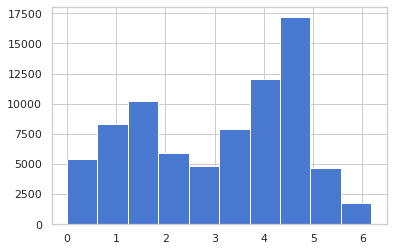

In [76]:
plt.hist(ta.track_data['ha'])

In [ ]:
si =

In [85]:
a = dict(x=1, y=2, z=10)
b = dict(x=1, y=np.array(3))

def dict_diff(a, b):
    "returns a dictionary with entries that are either different in b or additional"
    c = {}
    for k, v in b.items():
        if k in a:
            if a[k]!=v:
                c[k]=v
        else:
            c[k]=v
    return c

dict_diff(a,b)

{'y': array(3)}

In [14]:
sns.scatterplot(x='of_hd_ang',y='tm_uz_mag_rw', hue='cluster', data=table, palette='Set2')

ValueError: Could not interpret value `tm_uz_mag_rw` for parameter `y`

<AxesSubplot:xlabel='tm_All', ylabel='Count'>

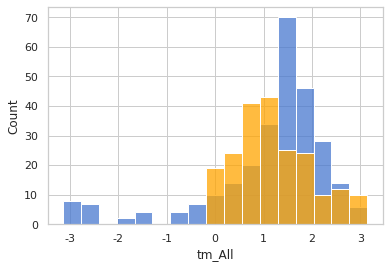

In [31]:
bins = np.linspace(-np.pi,np.pi,18)
sns.histplot(table['tm_All'].apply(np.angle), bins=bins)
sns.histplot(table['of_hd_ang'].astype(float), bins=bins, color='orange')
# bins = np.linspace(0,360,18)
# sns.histplot(np.rad2deg(table['tm_All'].apply(np.angle)), bins=bins)
# sns.histplot(np.rad2deg(table['of_hd_ang'].astype(float)), bins=bins, color='orange')


In [40]:
def rotate_rad_0_to_2pi(theta):
    theta2 = theta.copy()
    theta2[theta2<0] = 2*np.pi + theta2[theta2<0] 
    return theta2


<AxesSubplot:xlabel='tm_All', ylabel='Count'>

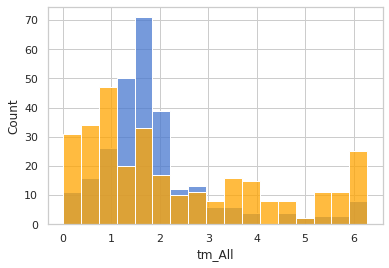

In [41]:
bins = np.linspace(0,2*np.pi,18)
sns.histplot(rotate_rad_0_to_2pi(table['tm_All'].apply(np.angle)), bins=bins)
sns.histplot(table['of_hd_ang'].astype(float), bins=bins, color='orange')

In [46]:
stats.circmean(rotate_rad_0_to_2pi(table['tm_All'].apply(np.angle)), nan_policy='omit'), stats.circmean(table['of_hd_ang'].astype(float), nan_policy='omit')

(1.5312316921287432, 0.9125029581278984)

In [58]:
tm_ang = rotate_rad_0_to_2pi(table['tm_All'].apply(np.angle))
of_ang = table['of_hd_ang'].astype(float)

df = table.copy()
df['tm_ang'] = tm_ang
df['of_ang'] = of_ang

<AxesSubplot:xlabel='tm_CR', ylabel='Count'>

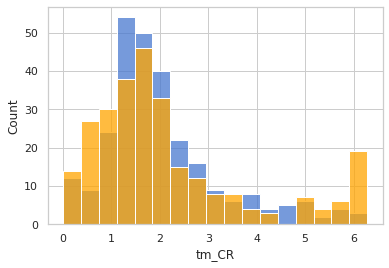

In [65]:
tm_ang_cr = rotate_rad_0_to_2pi(table['tm_CR'].apply(np.angle))
tm_ang_cl = rotate_rad_0_to_2pi(table['tm_CL'].apply(np.angle))
sns.histplot(tm_ang_cr, bins=bins)
sns.histplot(tm_ang_cl, bins=bins, color='orange')


In [102]:
cue_delta = table['tm_CR']-table['tm_CL']
cue_delta_ang = rotate_rad_0_to_2pi(np.angle(cue_delta))
cue_delta_mag= np.abs(cue_delta)

df['tm_cue_delta_ang'] = cue_delta_ang
df['tm_cue_delta_mag'] = cue_delta_mag

rw_delta = table['tm_Co']-table['tm_Inco']
rw_delta_ang = rotate_rad_0_to_2pi(np.angle(rw_delta))
rw_delta_mag= np.abs(rw_delta)

df['tm_rw_delta_ang'] = rw_delta_ang
df['tm_rw_delta_mag'] = rw_delta_mag


<AxesSubplot:ylabel='Count'>

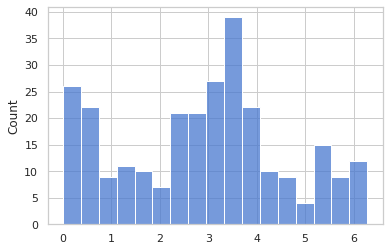

In [97]:

sns.histplot(cue_delta_ang, bins=bins)

<AxesSubplot:ylabel='Count'>

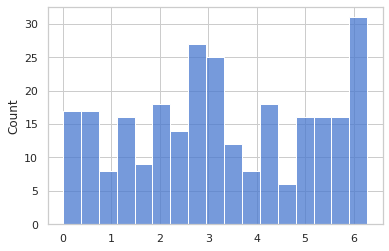

In [98]:
sns.histplot(rw_delta_ang, bins=bins)

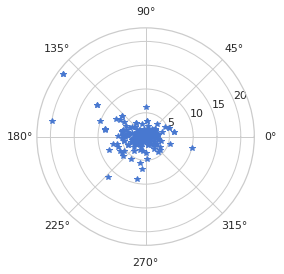

In [75]:
plt.polar(cue_delta_ang[[cue_delta_mag<30]], cue_delta_mag[cue_delta_mag<30], '*')

(-2.0, 25.0)

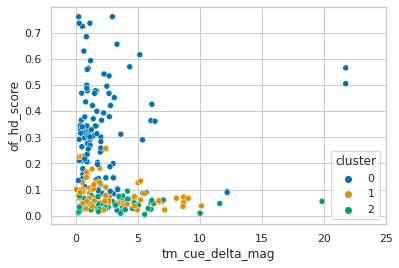

In [92]:
#sns.scatterplot(x='tm_cue_delta_ang', y='tm_remap_cue', hue='cluster', data=df,palette='colorblind')
ax = sns.scatterplot(x='tm_cue_delta_mag', y='of_hd_score', hue='cluster', data=df,palette='colorblind')
ax.set_xlim([-2,25])

#plt.scatter(cue_delta_mag, table['tm_remap_cue'])

(-2.0, 25.0)

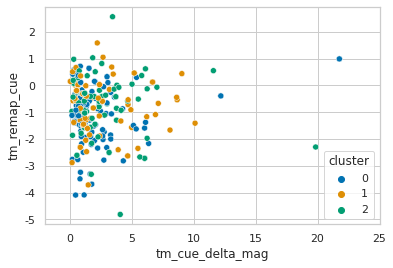

In [93]:
ax = sns.scatterplot(x='tm_cue_delta_mag', y='tm_remap_cue', hue='cluster', data=df,palette='colorblind')
ax.set_xlim([-2,25])

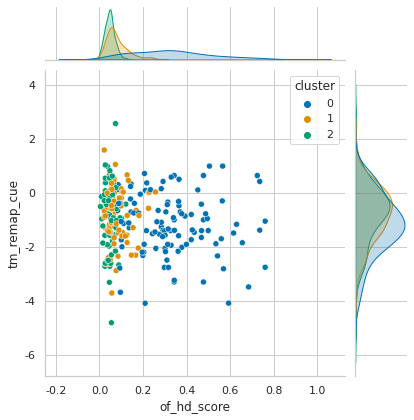

In [95]:
ax = sns.jointplot(x='of_hd_score', y='tm_remap_cue', hue='cluster', data=df,palette='colorblind')


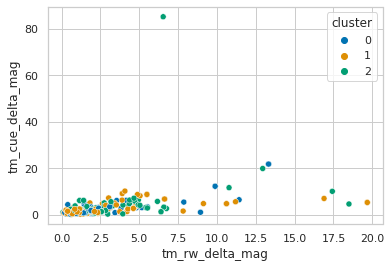

In [104]:
ax = sns.scatterplot(x='tm_rw_delta_mag', y='tm_cue_delta_mag', hue='cluster', data=df,palette='colorblind')


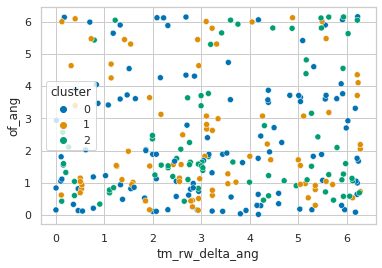

In [108]:
ax = sns.scatterplot(x='tm_rw_delta_ang', y='of_ang', hue='cluster', data=df,palette='colorblind')

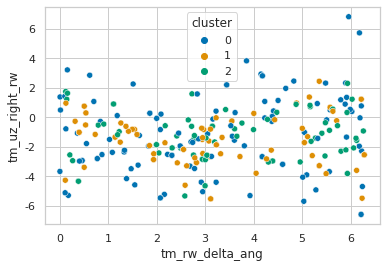

In [114]:
ax = sns.scatterplot(x='tm_rw_delta_ang', y='tm_uz_right_rw', hue='cluster', data=df,palette='colorblind')

(-2.0, 25.0)

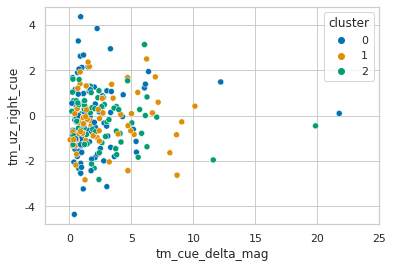

In [117]:
ax = sns.scatterplot(x='tm_cue_delta_mag', y='tm_uz_right_cue', hue='cluster', data=df,palette='colorblind')
ax.set_xlim([-2,25])

<AxesSubplot:xlabel='cluster', ylabel='tm_cue_delta_mag'>

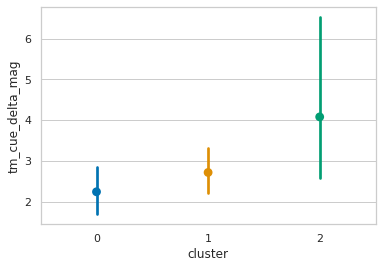

In [126]:
sns.pointplot(x='cluster', y='tm_cue_delta_mag', data=df,palette='colorblind')
#sns.stripplot(x='cluster', y='tm_cue_delta_mag', data=df,palette='colorblind', alpha=0.1)

<AxesSubplot:xlabel='cluster', ylabel='tm_rw_delta_mag'>

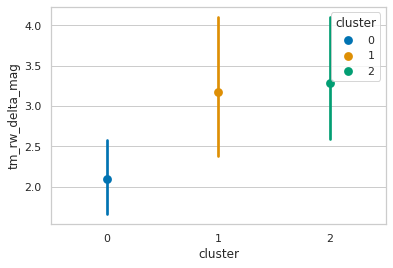

In [128]:
sns.pointplot(x='cluster', y='tm_rw_delta_mag', hue='cluster', data=df,palette='colorblind')

<AxesSubplot:xlabel='cluster', ylabel='tm_uz_right_cue'>

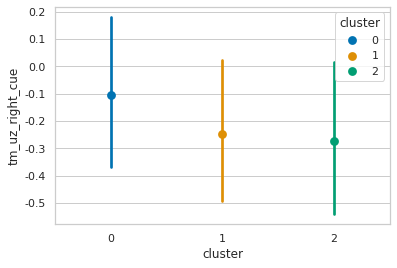

In [129]:
sns.pointplot(x='cluster', y='tm_uz_right_cue', hue='cluster', data=df,palette='colorblind')


<AxesSubplot:xlabel='cluster', ylabel='tm_uz_left_cue'>

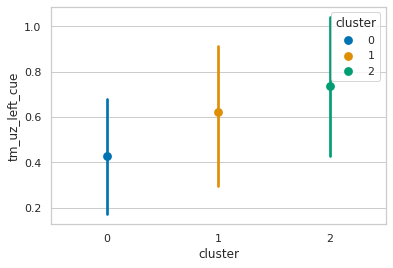

In [130]:
sns.pointplot(x='cluster', y='tm_uz_left_cue', hue='cluster', data=df,palette='colorblind')

<AxesSubplot:xlabel='cluster', ylabel='tm_cue_delta_ang'>

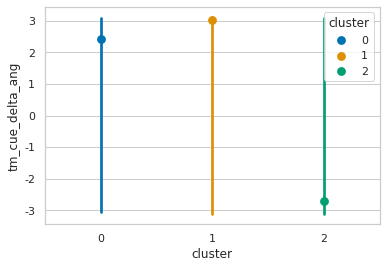

In [136]:
sns.pointplot(x='cluster', y='tm_cue_delta_ang', hue='cluster', data=df,palette='colorblind', estimator=rs.circ_mean)

<AxesSubplot:xlabel='cluster', ylabel='of_ang'>

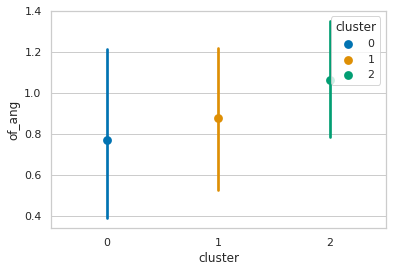

In [138]:
sns.pointplot(x='cluster', y='of_ang', hue='cluster', data=df,palette='colorblind', estimator=rs.circ_mean)

<AxesSubplot:xlabel='cluster', ylabel='tm_ang'>

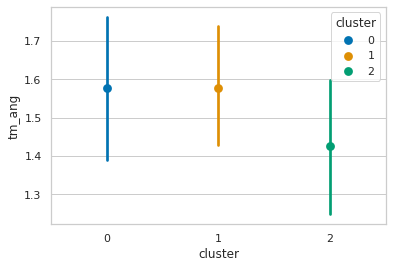

In [139]:
sns.pointplot(x='cluster', y='tm_ang', hue='cluster', data=df,palette='colorblind', estimator=rs.circ_mean)

<AxesSubplot:ylabel='tm_cue_delta_ang'>

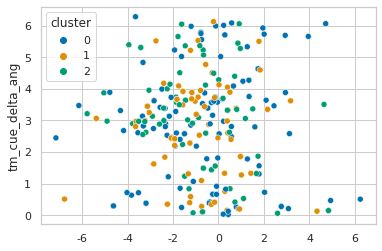

In [146]:
sns.scatterplot(df.tm_uz_right_cue-df.tm_uz_left_cue, df.tm_cue_delta_ang, hue=df.cluster, palette='colorblind')

In [148]:
df.columns

Index(['match_cl_id', 'match_pair_number', 'cluster', 'subject', 'umap_1',
       'umap_2', 'of_hd_ang', 'of_hd_score', 'tm_uz_stem_cue',
       'tm_uz_left_cue', 'tm_uz_right_cue', 'tm_uz_stem_rw', 'tm_uz_left_rw',
       'tm_uz_right_rw', 'tm_remap_cue', 'tm_remap_rw', 'tm_All', 'tm_CR',
       'tm_CL', 'tm_Co', 'tm_Inco', 'tm_ang', 'of_ang', 'tm_cue_delta_ang',
       'tm_cue_delta_mag', 'tm_rw_delta_ang', 'tm_rw_delta_mag'],
      dtype='object')

<AxesSubplot:xlabel='tm_All', ylabel='of_hd_score'>

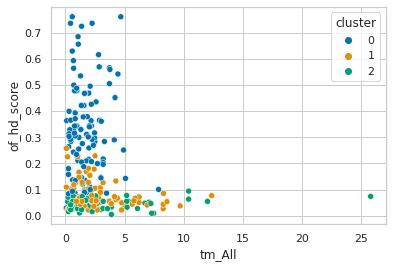

In [152]:
sns.scatterplot(np.abs(df.tm_All), df.of_hd_score,  hue=df.cluster, palette='colorblind')

<AxesSubplot:xlabel='of_hd_score', ylabel='tm_All'>

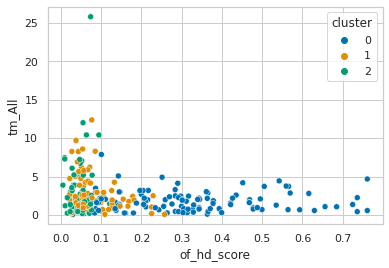

In [155]:
sns.scatterplot(df.of_hd_score, np.abs(df.tm_All),  hue=df.cluster, palette='colorblind')

<AxesSubplot:xlabel='of_hd_score', ylabel='tm_remap_cue'>

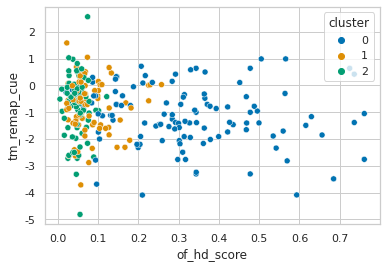

In [156]:
sns.scatterplot(df.of_hd_score, df.tm_remap_cue,  hue=df.cluster, palette='colorblind')

<AxesSubplot:xlabel='of_ang'>

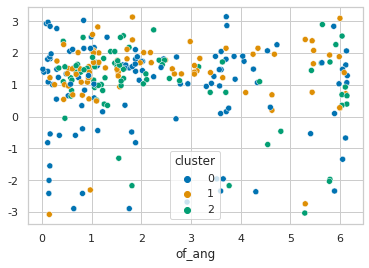

In [160]:
sns.scatterplot(df.of_ang, np.angle(df.tm_Co),  hue=df.cluster, palette='colorblind')

<AxesSubplot:xlabel='of_ang'>

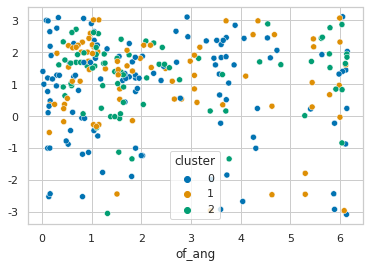

In [161]:
sns.scatterplot(df.of_ang, np.angle(df.tm_Inco),  hue=df.cluster, palette='colorblind')

<AxesSubplot:xlabel='of_ang', ylabel='tm_rw_delta_ang'>

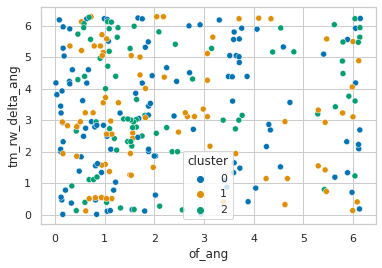

In [162]:
sns.scatterplot(df.of_ang, df.tm_rw_delta_ang,  hue=df.cluster, palette='colorblind')

In [ ]:
sns.pointplot(x='cluster', y='tm_ang', hue='cluster', data=df,palette='colorblind', estimator=rs.circ_mean)

In [134]:
?sns.barplot

Signature:
sns.barplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    estimator=<function mean at 0x7fb0180e21f0>,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    errcolor='.26',
    errwidth=None,
    capsize=None,
    dodge=True,
    ax=None,
    **kwargs,
)
Docstring:
Show point estimates and confidence intervals as rectangular bars.

A bar plot represents an estimate of central tendency for a numeric
variable with the height of each rectangle and provides some indication of
the uncertainty around that estimate using error bars. Bar plots include 0
in the quantitative axis range, and they are a good choice when 0 is a
meaningful value for the quantitative variable, and you want to make
comparisons against it.

For datasets where 0 is not a meaningful value, a point plot will allow you
to focus on differences between levels of one or more catego

(array([261.,   9.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([6.04048451e-02, 8.58194696e+00, 1.71034891e+01, 2.56250312e+01,
        3.41465733e+01, 4.26681154e+01, 5.11896576e+01, 5.97111997e+01,
        6.82327418e+01, 7.67542839e+01, 8.52758260e+01]),
 <BarContainer object of 10 artists>)

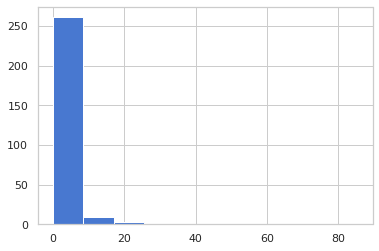

In [74]:
plt.hist(cue_delta_mag)

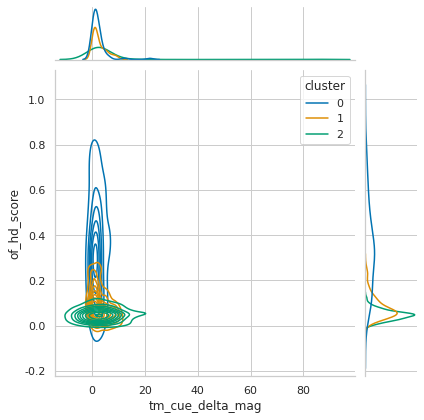

In [90]:
#sns.jointplot(x='of_ang', y='tm_ang', hue='cluster', data=df, palette='colorblind')
sns.jointplot(x='tm_cue_delta_mag', y='of_hd_score', hue='cluster', data=df, palette='colorblind', kind='kde')


In [51]:
pd.DataFrame((tm_ang,of_ang)).T

,tm_All,of_hd_ang
tm_All,1.000000,-0.012354
of_hd_ang,-0.012354,1.000000


In [6]:
print(table.columns)
table.head()

Index(['match_cl_id', 'match_pair_number', 'cluster', 'subject', 'umap_1',
       'umap_2', 'of_hd_ang', 'of_hd_score', 'tm_uz_stem_cue',
       'tm_uz_left_cue', 'tm_uz_right_cue', 'tm_uz_stem_rw', 'tm_uz_left_rw',
       'tm_uz_right_rw', 'tm_remap_cue', 'tm_remap_rw'],
      dtype='object')


,match_cl_id,match_pair_number,cluster,subject,umap_1,umap_2,of_hd_ang,of_hd_score,tm_uz_stem_cue,tm_uz_left_cue,tm_uz_right_cue,tm_uz_stem_rw,tm_uz_left_rw,tm_uz_right_rw,tm_remap_cue,tm_remap_rw
0,0,0,0,Li,-3.854654,2.271504,1.076356,0.365053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,0,Li,-3.854654,2.271504,1.076356,0.365053,0.1844,1.661583,-1.856163,-5.755994,2.040715,-0.171802,-0.477471,-0.992209
2,1,0,1,Li,2.951423,0.263405,1.56612,0.055527,0.498023,0.457152,-0.290957,-3.892735,0.21039,-4.608173,0.202963,-1.901687
3,1,1,1,Li,2.951423,0.263405,1.56612,0.055527,0.26513,-0.824801,-0.449661,-5.26301,2.696086,-3.089598,-0.478512,-1.335404
4,2,0,2,Li,9.045257,-0.002619,1.223314,0.05834,1.137033,1.080373,-2.335737,-4.825928,1.771543,-2.962975,-0.183025,-0.372746


(array([ 44., 133.,  56.,   6.,   0.,   0.,   5.,   9.,   6.,  15.]),
 array([8.39533983e-03, 9.36655950e-01, 1.86491656e+00, 2.79317717e+00,
        3.72143778e+00, 4.64969839e+00, 5.57795900e+00, 6.50621961e+00,
        7.43448022e+00, 8.36274083e+00, 9.29100144e+00]),
 <BarContainer object of 10 artists>)

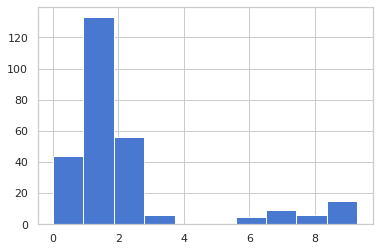

In [39]:
plt.hist(rotate_rad_0_to_2pi(table['tm_All'].apply(np.angle)))

In [18]:
np.rad2deg(table['of_hd_ang'].astype(float))

0       61.670630
1       61.670630
2       89.732046
3       89.732046
4       70.090714
          ...    
302    323.558534
303    311.749037
304    311.749037
305     62.899486
306    215.394498
Name: of_hd_ang, Length: 307, dtype: float64

#### for every TM/OF matched unit. extract the relevant information

In [15]:
ei = reload(ei)
info = ei.SummaryInfo()
o = info.select_session()

interactive(children=(Dropdown(description='subject', options=('Li', 'Ne', 'Cl', 'Al', 'Ca', 'Mi'), value='Li'…

In [16]:
session_info = o.result
print(session_info)


Session Information for subject Li, session Li_T3g_061418
Number of curated units: 22
Methods listed below can be executed with get_{method}(), eg. get_spikes():
  -> track_data. Executed = True
  -> spikes. Executed = True
  -> binned_spikes. Executed = True
  -> fr. Executed = True
  -> pos_zones. Executed = True
  -> event_table. Executed = True
  -> trial_zone_rates. Executed = False
  -> zone_rates_comps. Executed = True
  -> zone_rates_remap. Executed = True
  -> pop_zone_rates_remap. Executed = True
  -> bal_conds_seg_rates. Executed = True
  -> bal_conds_seg_boot_rates. Executed = nan
  -> zone_encoder. Executed = True
  -> zone_decoder. Executed = True

To run all analyses use run_analyses().



In [18]:
mr = session_info.get_bigseg_cond_rates()
mr.head()

,CR_out_left_m,CR_out_left_z,CR_out_left_n,CR_out_stem_m,CR_out_stem_z,CR_out_stem_n,CR_out_right_m,CR_out_right_z,CR_out_right_n,CR_in_left_m,...,All_out_right_n,All_in_left_m,All_in_left_z,All_in_left_n,All_in_stem_m,All_in_stem_z,All_in_stem_n,All_in_right_m,All_in_right_z,All_in_right_n
0,15.178610,2.041763,18.0,11.197572,4.542450,99.0,10.166655,3.643740,84.0,8.669176,...,125.0,9.930801,2.345988,73.0,7.951601,1.789860,194.0,14.945071,2.943528,125.0
1,3.579410,2.633183,18.0,1.440062,2.286576,99.0,2.372559,1.764392,84.0,3.518344,...,125.0,3.946964,1.415915,73.0,0.725945,0.674713,194.0,1.539618,1.187218,125.0
2,15.926382,2.969489,18.0,6.249656,3.313919,99.0,3.902749,1.631102,84.0,19.025632,...,125.0,15.535548,2.693516,73.0,8.984043,1.879651,194.0,16.972901,2.305772,125.0
3,2.620753,1.521196,18.0,0.957739,0.943809,99.0,0.050601,0.207206,84.0,5.247557,...,125.0,4.638013,1.398612,73.0,0.436065,0.296760,194.0,1.002170,0.779899,125.0
4,4.364842,1.814528,18.0,6.022826,4.204548,99.0,4.493827,2.042723,84.0,3.733136,...,125.0,4.694458,1.474556,73.0,4.503604,1.794501,194.0,2.658093,1.084650,125.0


In [87]:
ta = tmf.TrialAnalyses(session_info)

In [96]:
%%time
tmf = reload(tmf)
mr = tmf.mean_segment_rates_analysis(session_info, ta)

CPU times: user 659 ms, sys: 0 ns, total: 659 ms
Wall time: 657 ms


In [85]:
mr['CR_out_left_m'].values

array([ 6.53028739, 17.18486647,  2.7248441 ,  6.73060605,  1.13457139,
       11.97369261,  5.96182779,  3.28743767,  2.85186534,  2.71618787,
       36.22237827,  5.70353746,  1.64630073,  2.14451206,  1.22301951,
        5.27778214, 42.510307  ,  1.12500565,  2.78221737,  3.59015282,
        5.02191141])

In [110]:
[c for c in mr.columns if '_z' in c]

['CR_out_left_z',
 'CR_out_stem_z',
 'CR_out_right_z',
 'CR_in_left_z',
 'CR_in_stem_z',
 'CR_in_right_z',
 'CL_out_left_z',
 'CL_out_stem_z',
 'CL_out_right_z',
 'CL_in_left_z',
 'CL_in_stem_z',
 'CL_in_right_z',
 'Co_out_left_z',
 'Co_out_stem_z',
 'Co_out_right_z',
 'Co_in_left_z',
 'Co_in_stem_z',
 'Co_in_right_z',
 'Inco_out_left_z',
 'Inco_out_stem_z',
 'Inco_out_right_z',
 'Inco_in_left_z',
 'Inco_in_stem_z',
 'Inco_in_right_z',
 'All_out_left_z',
 'All_out_stem_z',
 'All_out_right_z',
 'All_in_left_z',
 'All_in_stem_z',
 'All_in_right_z']

In [19]:
%%time
def tm_hdt_cond(data, cond, activity_type='z'):
    all_cols = data.columns
    
    assert activity_type in ['m', 'z']
    cond_cols = [c for c in all_cols if ((c.split('_')[0]==cond) & (c.split('_')[-1]==activity_type))]

    oi_cols = {}
    oi_cols['out'] = [c for c in cond_cols if (c.split('_')[1]=='out')]
    oi_cols['in'] = [c for c in cond_cols if (c.split('_')[1]=='in')]
            
    df = pd.DataFrame(index = range(data.shape[0]))
    for s, oi in zip([1,-1],['out', 'in']):
        for ang, seg in zip([np.pi/6, np.pi/2, 5/6*np.pi],['right','stem', 'left']):
            col = f"{cond}_{oi}_{seg}_{activity_type}"
            df[f"{seg}_{oi}"] = df[f"{seg}_{oi}"] = np.exp(s*ang*1j)*data[col]
            
    R = np.nansum(df,axis=1).astype(complex)

    out = pd.DataFrame(index = range(data.shape[0]))
    out['R'] = R.astype(complex)
    out['mag'] = np.abs(R).astype(float)
    out['ang'] = np.angle(R).astype(float)
    out.loc[out['mag']==0, f'ang'] = np.nan
    
    return out


conds = ['All','CR', 'CL', 'Co', 'Inco']
df = pd.DataFrame(index=range(mr.shape[0]), columns=conds)
for cond in conds:
    a = tm_hdt_cond(mr, cond)
    df[cond] = a['R'].astype(complex)


# a = tm_hdt_cond(mr, 'Co')
# b = tm_hdt_cond(mr, 'Inco')
# c = tm_hdt_cond(mr, 'All')

CPU times: user 50.6 ms, sys: 111 µs, total: 50.7 ms
Wall time: 44.7 ms


In [24]:
df[['a','b']] = np.zeros((), dtype=complex)
df

,All,CR,CL,Co,Inco,a,b
0,1.520383+3.655790j,2.772715+3.040434j,1.656236+3.971848j,1.365478+3.213840j,1.446199+3.611406j,0.0+0.0j,0.0+0.0j
1,-1.015433+2.266884j,-0.456101+2.420895j,-1.447384+2.211022j,-0.568377+2.200558j,-1.886736+2.641198j,0.0+0.0j,0.0+0.0j
2,-0.682656+0.838791j,-2.468991-0.172062j,0.674503+0.873747j,-0.336229+0.624739j,-5.778302-0.365147j,0.0+0.0j,0.0+0.0j
3,-1.326991+0.296950j,-1.918186+0.256718j,-1.443491+0.478320j,-0.899973+0.199352j,-2.896020+0.401644j,0.0+0.0j,0.0+0.0j
4,-0.287685+2.942287j,-0.381257+2.727050j,-0.037112+3.196079j,-0.141085+3.009341j,-1.045568+3.037662j,0.0+0.0j,0.0+0.0j
5,-0.847738+2.874138j,1.196953+3.186935j,-0.702449+1.693210j,0.106887+2.622912j,-2.384563+2.790852j,0.0+0.0j,0.0+0.0j
6,0.656625+3.198078j,0.855895+2.798057j,0.963211+3.481206j,0.470773+3.322400j,0.863603+3.177151j,0.0+0.0j,0.0+0.0j
7,0.350807+1.967103j,-0.563079+2.143467j,1.023910+1.914058j,0.566095+1.804543j,-0.156200+2.169626j,0.0+0.0j,0.0+0.0j
8,-0.434567+1.261844j,0.446458+1.068553j,-1.037146+1.340690j,0.145935+0.880866j,-0.568556+1.412531j,0.0+0.0j,0.0+0.0j
9,-0.400321+1.434528j,0.659552+1.357395j,-1.070438+1.445775j,-0.000741+1.156728j,-0.268154+1.529209j,0.0+0.0j,0.0+0.0j


In [119]:
np.abs(df).corr()

,All,CR,CL,Co,Inco
All,1.000000,0.920607,0.828246,0.979451,0.927722
CR,0.920607,1.000000,0.736884,0.921220,0.863774
CL,0.828246,0.736884,1.000000,0.799076,0.904973
Co,0.979451,0.921220,0.799076,1.000000,0.883250
Inco,0.927722,0.863774,0.904973,0.883250,1.000000


In [111]:
a

,R,mag,ang
0,0.023876+2.438963j,2.439080,1.561007
1,1.331267-0.701478j,1.504773,-0.484955
2,-0.639417-0.312722j,0.711793,-2.686723
3,0.953090-0.578520j,1.114928,-0.545546
4,0.291508+0.177840j,0.341473,0.547790
5,-1.103267-0.278926j,1.137980,-2.893964
6,1.225252+3.048719j,3.285716,1.188661
7,1.242590+1.976352j,2.334523,1.009520
8,1.034133+1.854499j,2.123346,1.062110
9,0.767414+1.996490j,2.138901,1.203826


<AxesSubplot:ylabel='Count'>

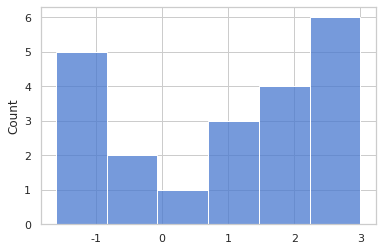

In [105]:
sns.histplot(np.angle(a['R']-b['R']))

<AxesSubplot:ylabel='Count'>

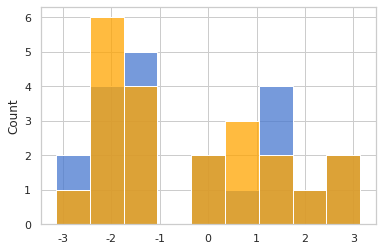

In [106]:
bins=np.linspace(-np.pi,np.pi,10)
sns.histplot(np.angle(a['R']), bins=bins)
sns.histplot(np.angle(b['R']), bins=bins, color='orange')

<AxesSubplot:ylabel='Count'>

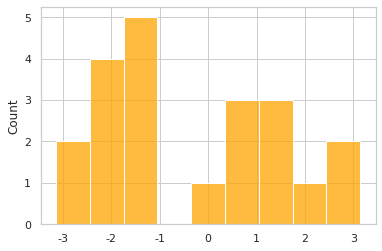

In [107]:
sns.histplot(np.angle(c['R']), bins=bins, color='orange')

In [ ]:
sns.histplot(np.angle(a['R']), bins=bins)
sns.histplot(np.angle(b['R']), bins=bins, color='orange')

In [68]:
sns.histplot?

Signature:
sns.histplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    weights=None,
    stat='count',
    bins='auto',
    binwidth=None,
    binrange=None,
    discrete=None,
    cumulative=False,
    common_bins=True,
    common_norm=True,
    multiple='layer',
    element='bars',
    fill=True,
    shrink=1,
    kde=False,
    kde_kws=None,
    line_kws=None,
    thresh=0,
    pthresh=None,
    pmax=None,
    cbar=False,
    cbar_ax=None,
    cbar_kws=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    color=None,
    log_scale=None,
    legend=True,
    ax=None,
    **kwargs,
)
Docstring:
Plot univariate or bivariate histograms to show distributions of datasets.

A histogram is a classic visualization tool that represents the distribution
of one or more variables by counting the number of observations that fall within
disrete bins.

This function can normalize the statistic computed within each bin to estimate
frequency, density or probability mass

In [ ]:
%%time
conds = ['CR', 'CL', 'Co', 'Inco', 'All']
trial_segs = ['out', 'in']
segs = ['left', 'stem', 'right']

cols = []
for c in conds:
    for ts in trial_segs:
        for s in segs:
            cols+= [f'{c}_{ts}_{s}_m', f'{c}_{ts}_{s}_z',  f'{c}_{ts}_{s}_n']

out = pd.DataFrame(index=range(ta.n_units), columns=cols)
for c in conds:
    cond_trials = ta.get_condition_trials(condition=c)
    for ts in trial_segs:
        cond_rates = ta.get_trial_segment_rates(trials=cond_trials, segment_type='bigseg', trial_seg=ts)
        for unit in range(ta.n_units):
            m = cond_rates[unit].mean()
            s = cond_rates[unit].std()
            n = (~cond_rates[0].isna()).sum()
            z = m/s
            for s in segs:
                out.loc[unit, f'{c}_{ts}_{s}_m'] = m[s]
                out.loc[unit, f'{c}_{ts}_{s}_z'] = z[s]
                out.loc[unit, f'{c}_{ts}_{s}_n'] = n[s]

In [ ]:
out

In [ ]:
out

In [ ]:
(cond_rates[0].mean()/cond_rates[0].std())['left']

In [ ]:
a
